<table>
<tr><td><img style="height: 150px;" src="images/geo_hydro1.jpg"></td>
<td bgcolor="#FFFFFF">
    <p style="font-size: xx-large; font-weight: 900; line-height: 100%">AG Dynamics of the Earth</p>
    <p style="font-size: large; color: rgba(0,0,0,0.5);">Jupyter notebooks</p>
    <p style="font-size: large; color: rgba(0,0,0,0.5);">Georg Kaufmann</p>
    </td>
</tr>
</table>

# Dynamic systems: 3. Continuity 
## Advection equation in 1D
----
*Georg Kaufmann,
Geophysics Section,
Institute of Geological Sciences,
Freie Universität Berlin,
Germany*

----
In this notebook, we solve a simple **transient advection equation** in one dimension,
using different numerical methods.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

----
## Theoretical model

We start defining the transient advection equation. We describe a quantity $c(x,t)$ in an incompressible fluid,
which changes its position only through advection of the particle quantity:
$$
c(x,t+\Delta t) = c(x-v \Delta t,t)
$$
with
$x$ [m] the position,
$t$ [s] time,
$v$ [m/s] the velocity, and
$\Delta t$ [s] the time increment.

We expand both sides of the equation into a **Taylor series** til the first-order term:
$$
c(x,t) + \Delta t \frac{\partial c(x,t)}{\partial t}
\simeq
c(x,t) - v \Delta t \frac{\partial c(x,t)}{\partial x}
$$
which can be recasted into the `transient advection equation`:
$$
\fbox{$
\frac{\partial c(x,t)}{\partial t} + v \frac{\partial c(x,t)}{\partial x} = 0
$}
$$

The transient advection equation is a **hyperbolic partial differential equation**, which has a unique
solution for the **initial condition**:
$$
c(x,t=0) = c_0(x,0)
$$

----
## Gaussian function

We define the `Gaussian` function with mean $\mu$ and standard deviation $\sigma$:
$$
c(x,t) = e^{-\frac{(x-vt-\mu)^2}{\sigma^2}}
$$
which is a solution of the transient advection equation.

In [2]:
def gaussian(x,v=0.5,t=0.,mu=2.,sigma=1.):
    f = np.exp(-(x-v*t-mu)**2/(sigma)**2)
    return f

In [3]:
xstep = 101
x = np.linspace(0,10,xstep)   # m

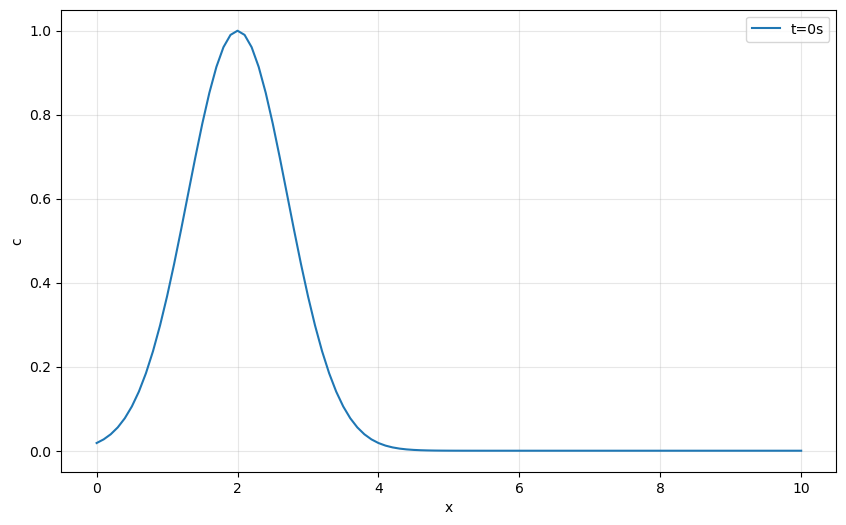

In [4]:
u0 = gaussian(x)

plt.figure(figsize=(10,6))
plt.xlabel('x')
plt.ylabel('c')
plt.grid(alpha=0.3)
plt.plot(x,u0,label='t=0s')
#plt.plot(x,gaussian(x,t=4),label='t=4s')
#plt.plot(x,gaussian(x,t=8),label='t=8s')
#plt.plot(x,gaussian(x,t=10),label='t=10s')
plt.legend()

----
## Numerical solution methods

Next, we derive several numerical methods, which can be used to solve the transient advection equation.
We first need to assign the temporal and spatial time steps, $\Delta t$ [s] and $\Delta x$ [m], 
and the velocity $c$ [m/s]:

In [5]:
dt = 0.05  # s
dx = (x.max()-x.min()) / (xstep-1)   # m
v  = 0.5   # m/s

Thus we have discretised both spatial and temporal variables:
$$
\begin{array}{rcl}
t_n &=& t_0 + n \Delta t, \quad n=0,N \\
x_i &=& x_0 + i \Delta x, \quad i=0,I
\end{array}
$$

The `Courant number`, defined as
$$
Co = \frac{v \Delta t}{\Delta x}
$$
defines the stability of the numerical solutions. Explicit solutions are stable
for $Co <1$.

In [6]:
Courant = v*dt/dx
print ('Courant number: ',Courant)

Courant number:  0.25


----
## FTCS scheme (forward time centered space)

Our first scheme is called `FTCS`, forward time, centered space, thus the derivatives in the
transient advection equations are replaced by **forward differences in time** and 
**central differences is space**:
$$
\frac{c_{i}^{n+1}-c_{i}^{n}}{\Delta t}
=
-v \frac{c_{i+1}^{n}-c_{i-1}^{n}}{2 \Delta x}
$$
or solved for the next time step
$$
c_{i}^{n+1}
=
c_{i}^{n} -\frac{v \Delta t}{2 \Delta x} \left( c_{i+1}^{n}-c_{i-1}^{n} \right)
$$

<img src="images/PDE_FTCS.jpg" style="height:5cm;">

We implement the FTCS method:

In [7]:
# start time
t = 0
# initial values
u = gaussian(x)

# solution
for n in range(200):
    t = t + dt
    uold = u
    for i in range(1,u.shape[0]-1):
        u[i] = uold[i] - v*dt/2/dx*(uold[i+1]-uold[i-1])
    if (np.abs(t-4) < dt/2):
        u04 = np.copy(u)
    elif (np.abs(t-8) < dt/2):
        u08 = np.copy(u)
    elif (np.abs(t-10) < dt/2):
        u10 = np.copy(u)

In [8]:
print(x[np.where(u0 == np.amax(u0))],u0[np.where(u0 == np.amax(u0))])
print(x[np.where(u04 == np.amax(u04))],u04[np.where(u04 == np.amax(u04))])
print(x[np.where(u08 == np.amax(u08))],u08[np.where(u08 == np.amax(u08))])
print(x[np.where(u10 == np.amax(u10))],u10[np.where(u10 == np.amax(u10))])

[2.] [1.]
[4.3] [0.99708186]
[6.5] [0.99722908]
[7.6] [0.99472472]


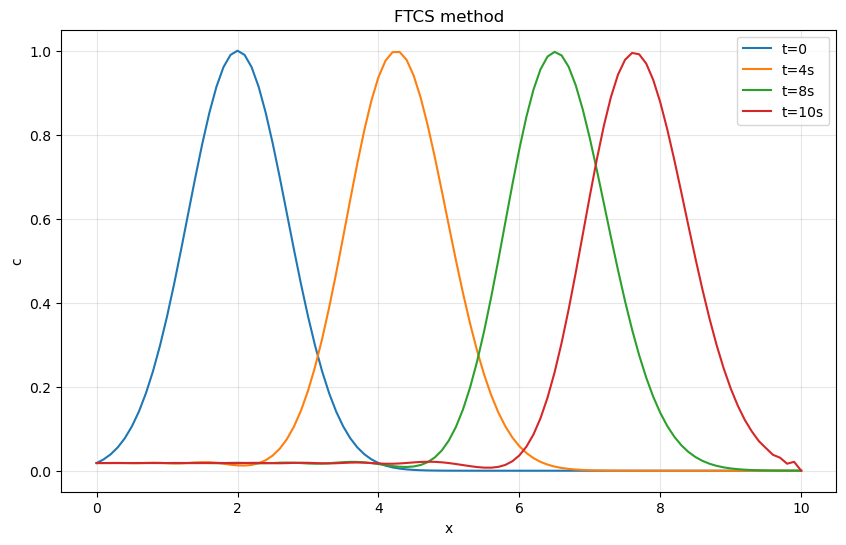

In [9]:
plt.figure(figsize=(10,6))
plt.xlabel('x')
plt.ylabel('c')
plt.grid(alpha=0.3)
plt.plot(x,u0,label='t=0')
plt.plot(x,u04,label='t=4s')
plt.plot(x,u08,label='t=8s')
plt.plot(x,u10,label='t=10s')
plt.title('FTCS method')
plt.legend()

----
## Upwind scheme

Our second scheme is from the group of `upwind scheme`, which promote a solution skewed in the direction
of the advective flow, thus on $c$. We keep the **forward operator in time**, and implement either
a **backward** or **forward operator in space**, depending of the sign of $c$:
$$
\begin{array}{rcl}
\frac{c_{i}^{n+1}-c_{i}^{n}}{\Delta t} &=& -v \frac{c_{i}^{n}-c_{i-1}^{n}}{\Delta x}, \quad c>0 \\
\frac{c_{i}^{n+1}-c_{i}^{n}}{\Delta t} &=& -v \frac{c_{i+1}^{n}-c_{i}^{n}}{\Delta x}, \quad c<0 
\end{array}
$$
or solved for the next time step
$$
\begin{array}{rcl}
c_{i}^{n+1} &=& c_{i}^{n}-\frac{v \Delta t}{\Delta x} \left( c_{i}^{n}-c_{i-1}^{n} \right), \quad c>0 \\
c_{i}^{n+1} &=& c_{i}^{n}-\frac{v \Delta t}{\Delta x} \left( c_{i+1}^{n}-c_{i}^{n} \right), \quad c<0 
\end{array}
$$

<img src="images/PDE_upwind.jpg" style="height:5cm;">

We implement the upwind method:

In [10]:
# start time
t = 0
# initial values
u = gaussian(x)

# solution
for n in range(200):
    t = t + dt
    uold = u
    for i in range(1,u.shape[0]-1):
        u[i] = uold[i] - v*dt/dx*(uold[i]-uold[i-1])
    if (np.abs(t-4) < dt/2):
        u04 = np.copy(u)
    elif (np.abs(t-8) < dt/2):
        u08 = np.copy(u)
    elif (np.abs(t-10) < dt/2):
        u10 = np.copy(u)

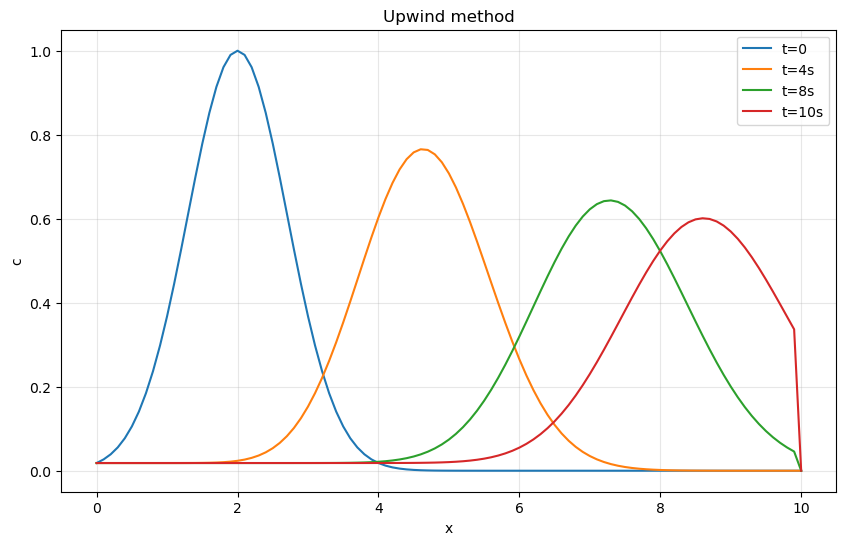

In [11]:
plt.figure(figsize=(10,6))
plt.xlabel('x')
plt.ylabel('c')
plt.grid(alpha=0.3)
plt.plot(x,u0,label='t=0')
plt.plot(x,u04,label='t=4s')
plt.plot(x,u08,label='t=8s')
plt.plot(x,u10,label='t=10s')
plt.title('Upwind method')
plt.legend()

----
## Lax method

Our third scheme is called `Lax method`, it is derived from the FTCS method, but the term
$u_i^n$ is replaced by the average of its two neighbors:
$$
c_{i}^{n+1}
=
\frac{1}{2} \left( c_{i+1}^{n} + c_{i-1}^{n} \right) 
-\frac{v \Delta t}{2 \Delta x} \left( c_{i+1}^{n}-c_{i-1}^{n} \right)
$$

<img src="images/PDE_FTCS.jpg" style="height:5cm;">

We implement the LAX method:

In [12]:
# start time
t = 0
# initial values
u = gaussian(x)

# solution
for n in range(200):
    t = t + dt
    uold = u
    for i in range(1,u.shape[0]-1):
        u[i] = (uold[i+1]+uold[i-1])/2. - v*dt/2/dx*(uold[i+1]-uold[i-1])
    if (np.abs(t-4) < dt/2):
        u04 = np.copy(u)
    elif (np.abs(t-8) < dt/2):
        u08 = np.copy(u)
    elif (np.abs(t-10) < dt/2):
        u10 = np.copy(u)

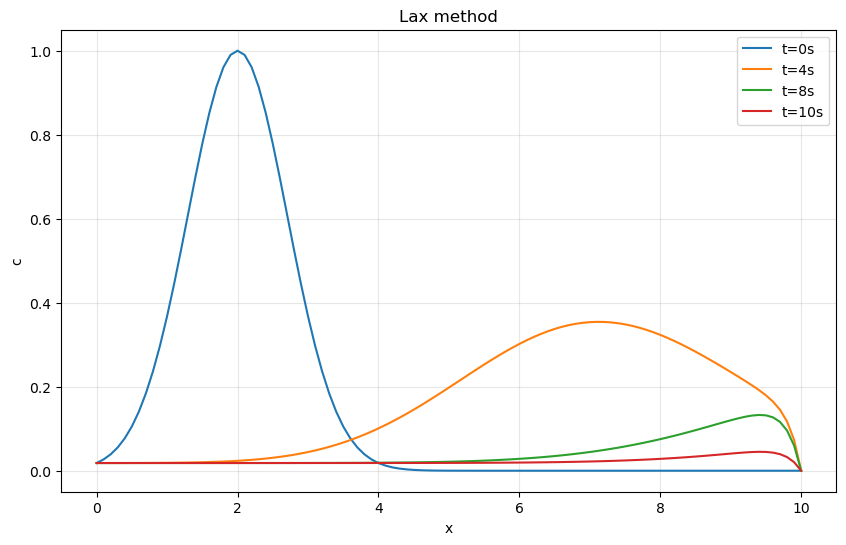

In [13]:
plt.figure(figsize=(10,6))
plt.xlabel('x')
plt.ylabel('c')
plt.grid(alpha=0.3)
plt.plot(x,u0,label='t=0s')
plt.plot(x,u04,label='t=4s')
plt.plot(x,u08,label='t=8s')
plt.plot(x,u10,label='t=10s')
plt.title('Lax method')
plt.legend()

----
## Lax-Wendroff method

Our fourth scheme is called `Lax-Wendroff method`, it is a **two-step** procedure:
$$
\begin{array}{rcl}
c_{i-\frac{1}{2}}^{n+\frac{1}{2}} &=& \frac{1}{2} \left( c_{i-1}^{n} + c_{i}^{n} \right)
- \frac{v \Delta t}{2 \Delta x} \left( c_{i}^{n}-c_{i-1}^{n} \right) \\
c_{i+\frac{1}{2}}^{n+\frac{1}{2}} &=& \frac{1}{2} \left( c_{i}^{n} + c_{i+1}^{n} \right)
- \frac{v \Delta t}{2 \Delta x} \left( c_{i+1}^{n}-c_{i}^{n} \right) \\
c_{i}^{n+1} &=& u_{i}^{n} - \frac{v \Delta t}{\Delta x}
\left( c_{i+\frac{1}{2}}^{n+\frac{1}{2}} - c_{i-\frac{1}{2}}^{n+\frac{1}{2}}\right)
\end{array}
$$

<img src="images/PDE_LAX_WENDROFF.jpg" style="height:5cm;">

We implement the LAX-WENDROFF method:

In [14]:
# start time
t = 0
# initial values
u = gaussian(x)

# solution
for n in range(200):
    t = t + dt
    uold = u
    for i in range(1,u.shape[0]-1):
        uleft  = (uold[i-1]+uold[i])/2. - v*dt/2/dx*(uold[i]-uold[i-1])
        uright = (uold[i]+uold[i+1])/2. - v*dt/2/dx*(uold[i+1]-uold[i])
        u[i]   = uold[i] - v*dt/dx*(uright - uleft)
    if (np.abs(t-4) < dt/2):
        u04 = np.copy(u)
    elif (np.abs(t-8) < dt/2):
        u08 = np.copy(u)
    elif (np.abs(t-10) < dt/2):
        u10 = np.copy(u)

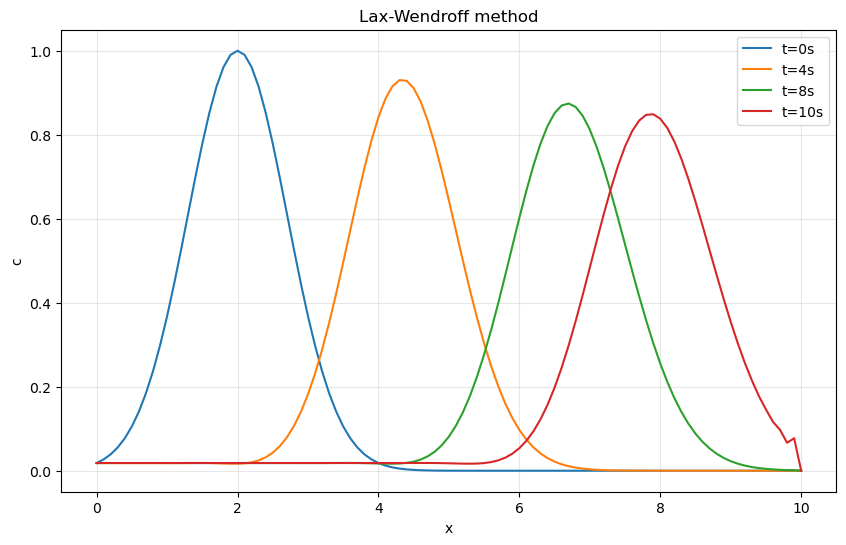

In [15]:
plt.figure(figsize=(10,6))
plt.xlabel('x')
plt.ylabel('c')
plt.grid(alpha=0.3)
plt.plot(x,u0,label='t=0s')
plt.plot(x,u04,label='t=4s')
plt.plot(x,u08,label='t=8s')
plt.plot(x,u10,label='t=10s')
plt.title('Lax-Wendroff method')
plt.legend()

... done

... [or explain](Dynamics_lab03_advection1DFails_noshow.ipynb)